## K-means


Generating walks (CPU: 1): 100%|██████████| 50/50 [00:00<00:00, 3249.18it/s]
/home/proffiterol/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Etichette dei cluster: [2 0 3 3 2 2 1 0 1]


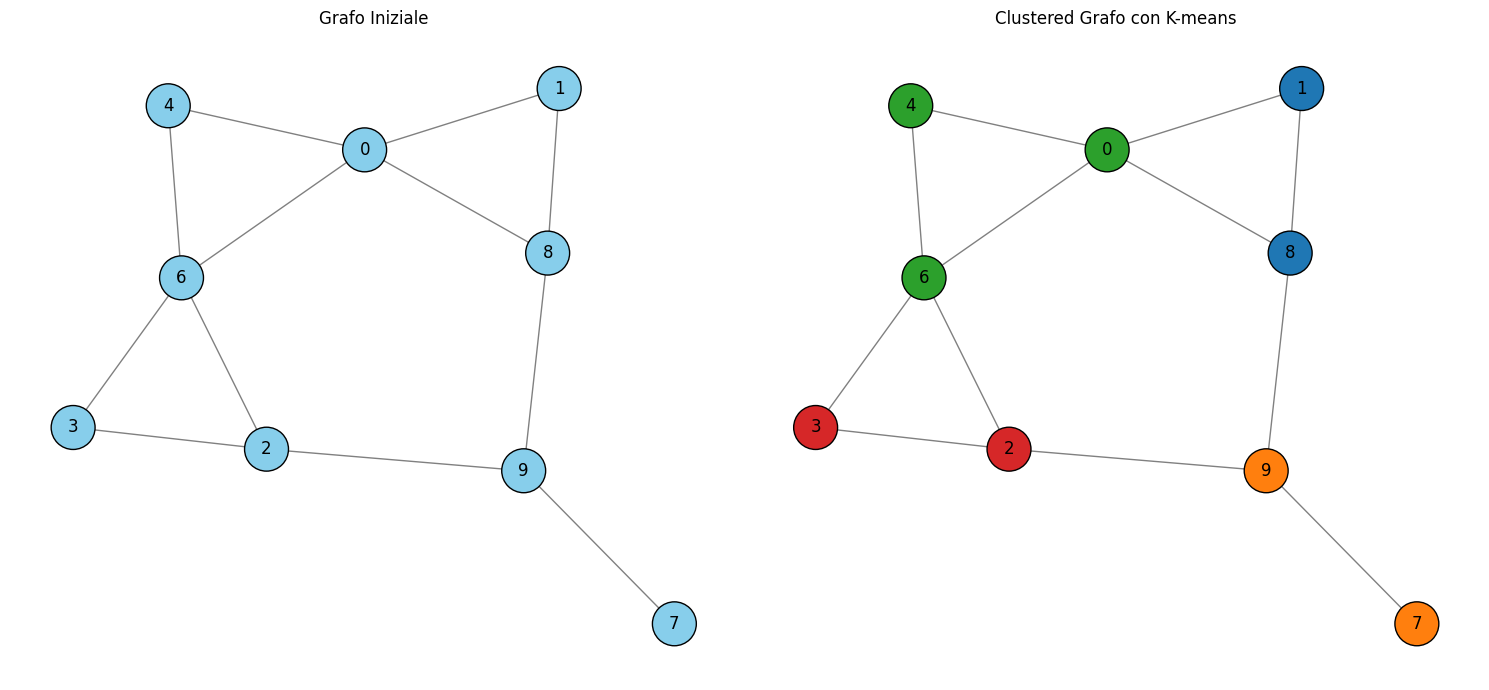

In [9]:
import networkx as nx
from node2vec import Node2Vec
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import itertools

# Definizione del grafo
class Graph:
    def __init__(self):
        self.grafo = {}

    def aggiungi_vertice(self, vertice):
        if vertice not in self.grafo:
            self.grafo[vertice] = []

    def aggiungi_arco(self, u, v):
        if u in self.grafo and v in self.grafo:
            self.grafo[u].append(v)
            self.grafo[v].append(u)

def converti_grafo_personalizzato_in_networkx(grafo_personalizzato):
    G = nx.Graph()
    for vertice, adiacenti in grafo_personalizzato.grafo.items():
        G.add_node(vertice)
        for adiacente in adiacenti:
            G.add_edge(vertice, adiacente)
    return G

def plot_graph(graph, ax, title, colors=None):
    pos = nx.spring_layout(graph, seed=42)
    labels = {node: str(node) for node in graph.nodes()}

    node_colors = {node: 'skyblue' for node in graph.nodes()}
    if colors:
        color_cycle = itertools.cycle(plt.cm.tab10.colors)
        for i, cluster in enumerate(colors):
            color = next(color_cycle)
            for node in cluster:
                node_colors[int(node)] = color

    nx.set_node_attributes(graph, node_colors, 'color')

    nx.draw(graph, pos, with_labels=True, labels=labels, node_size=1000, 
            node_color=list(node_colors.values()), ax=ax,
            font_size=12, font_color='black', edge_color='gray', 
            edgecolors='black', linewidths=1)

    ax.set_title(title)

# Creazione del grafo
grafo = Graph()
grafo.aggiungi_vertice(0)
grafo.aggiungi_vertice(1)
grafo.aggiungi_vertice(2)
grafo.aggiungi_vertice(3)
grafo.aggiungi_vertice(4)
grafo.aggiungi_vertice(6)
grafo.aggiungi_vertice(7)
grafo.aggiungi_vertice(8)
grafo.aggiungi_vertice(9)
grafo.aggiungi_arco(0, 8)
grafo.aggiungi_arco(0, 4)
grafo.aggiungi_arco(0, 6)
grafo.aggiungi_arco(1, 0)
grafo.aggiungi_arco(1, 8)
grafo.aggiungi_arco(6, 3)
grafo.aggiungi_arco(6, 4)
grafo.aggiungi_arco(6, 2)
grafo.aggiungi_arco(2, 9)
grafo.aggiungi_arco(3, 2)
grafo.aggiungi_arco(8, 9)
grafo.aggiungi_arco(9, 7)

# Conversione del grafo
G = converti_grafo_personalizzato_in_networkx(grafo)

# Creazione del modello Node2Vec
node2vec = Node2Vec(G, dimensions=20, walk_length=16, num_walks=50)

# Training del modello Node2Vec
model = node2vec.fit(window=7, min_count=1)

# Preparazione dei dati per k-means
nodes = sorted(G.nodes(), key=int)  # Sort nodes
data = np.array([model.wv[str(i)] for i in nodes])

# Applicazione dell'algoritmo k-means
kmeans = KMeans(n_clusters=4, random_state=42).fit(data)

# Ottenimento delle etichette dei cluster e stampa dei risultati
labels = kmeans.labels_
print("Etichette dei cluster:", labels)

# Creazione di una lista di clusters dal tuo modello k-means
clusters = [[] for _ in range(kmeans.n_clusters)]
for node, cluster_id in enumerate(labels):
    clusters[cluster_id].append(str(nodes[node]))  # Use sorted nodes

# Visualizzazione del grafo
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

plot_graph(G, axs[0], "Grafo Iniziale")
plot_graph(G, axs[1], "Clustered Grafo con K-means", colors=clusters)

plt.tight_layout()
plt.show()


## K-meams con ricerca locale

La ricerca locale può essere un valido strumento per migliorare i risultati dell'algoritmo k-means o di qualsiasi algoritmo di clustering. Invece di iniziare con un'assegnazione casuale di nodi ai cluster, si può iniziare con un'assegnazione che si basa su qualche forma di euristica o conoscenza pregressa. Poi, la ricerca locale può essere utilizzata per affinare questa assegnazione iniziale.

Nel contesto dell'algoritmo k-means, una strategia di ricerca locale potrebbe essere quella di iniziare con l'assegnazione casuale standard, ma poi spostare iterativamente i nodi da un cluster all'altro per vedere se questo riduce la somma delle distanze quadratiche. Questo è in realtà molto simile a ciò che l'algoritmo k-means fa già, ma potresti avere più flessibilità con una strategia di ricerca locale personalizzata. Ad esempio, potresti decidere di muovere più di un nodo alla volta, o di considerare non solo la distanza dal centro del cluster, ma anche altri fattori, come la densità del cluster.

Tuttavia, è importante notare che la ricerca locale può essere un processo computazionalmente intensivo, specialmente per grafi grandi, e non c'è garanzia che troverà la soluzione ottimale. Inoltre, la ricerca locale può essere sensibile alla soluzione iniziale: se inizi con una cattiva assegnazione di nodi ai cluster, la ricerca locale potrebbe non essere in grado di "scappare" da una soluzione locale subottimale.

In definitiva, se vuoi utilizzare la ricerca locale con l'algoritmo k-means, ti consiglierei di sperimentare diverse strategie e vedere cosa funziona meglio per il tuo specifico problema.



La ricerca locale richiede una funzione obiettivo da ottimizzare e una strategia per esplorare lo spazio delle soluzioni. Nel caso del clustering, la funzione obiettivo potrebbe essere la somma delle distanze tra i punti di un cluster e il suo centro, che si vorrebbe minimizzare. Inoltre, uno spostamento da una soluzione all'altra potrebbe consistere nello spostamento di un punto da un cluster a un altro.

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:00<00:00, 1494.06it/s]


Etichette dei cluster: [2 2 1 1 2 2 0 3 0]


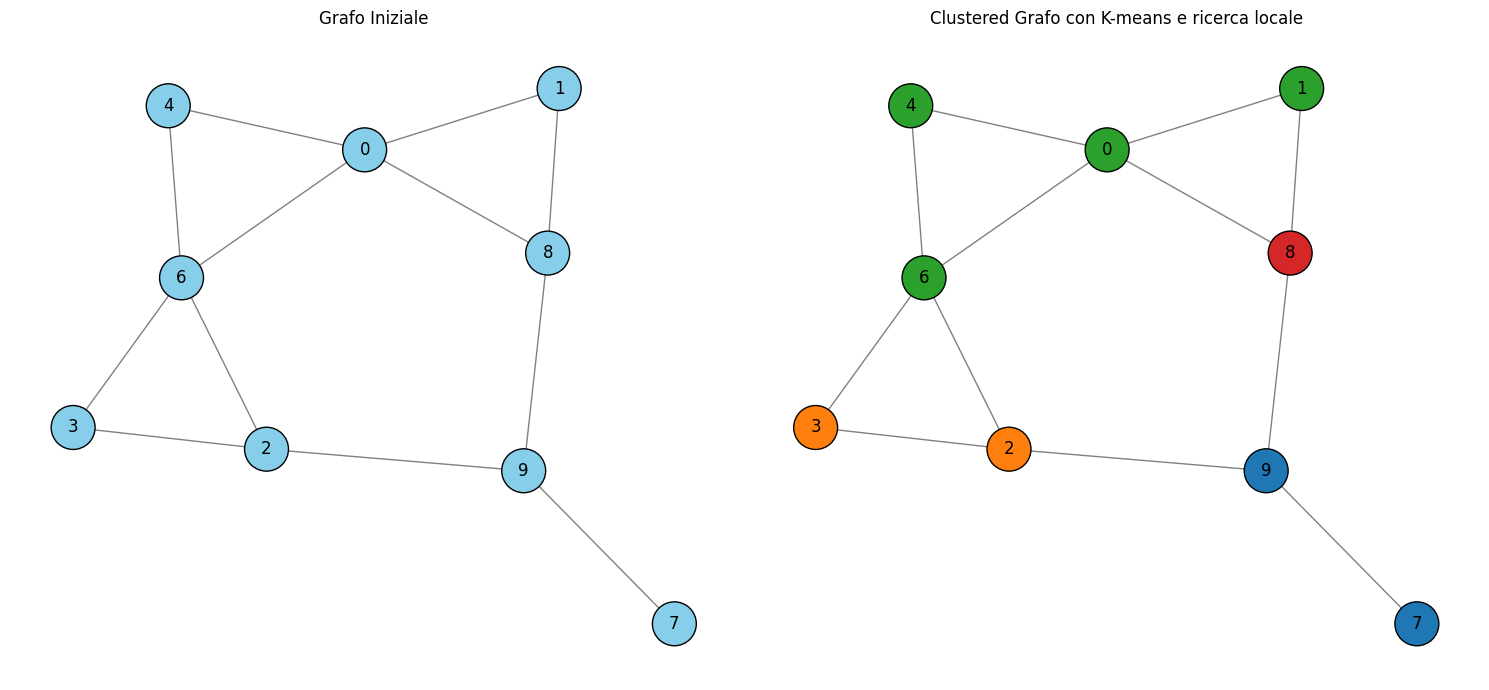

In [10]:
import networkx as nx
from node2vec import Node2Vec
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import itertools

# Definizione del grafo
class Graph:
    def __init__(self):
        self.grafo = {}

    def aggiungi_vertice(self, vertice):
        if vertice not in self.grafo:
            self.grafo[vertice] = []

    def aggiungi_arco(self, u, v):
        if u in self.grafo and v in self.grafo:
            self.grafo[u].append(v)
            self.grafo[v].append(u)

def converti_grafo_personalizzato_in_networkx(grafo_personalizzato):
    G = nx.Graph()
    for vertice, adiacenti in grafo_personalizzato.grafo.items():
        G.add_node(vertice)
        for adiacente in adiacenti:
            G.add_edge(vertice, adiacente)
    return G

def plot_graph(graph, ax, title, colors=None):
    pos = nx.spring_layout(graph, seed=42)
    labels = {node: str(node) for node in graph.nodes()}

    node_colors = {node: 'skyblue' for node in graph.nodes()}
    if colors:
        color_cycle = itertools.cycle(plt.cm.tab10.colors)
        for i, cluster in enumerate(colors):
            color = next(color_cycle)
            for node in cluster:
                node_colors[int(node)] = color

    nx.set_node_attributes(graph, node_colors, 'color')

    nx.draw(graph, pos, with_labels=True, labels=labels, node_size=1000, 
            node_color=list(node_colors.values()), ax=ax,
            font_size=12, font_color='black', edge_color='gray', 
            edgecolors='black', linewidths=1)

    ax.set_title(title)

# Creazione di una funzione obiettivo
def objective_function(data, labels, centers):
    total_distance = 0
    for i, label in enumerate(labels):
        total_distance += np.linalg.norm(data[i] - centers[label])
    return total_distance

# Creazione di una strategia di ricerca locale
def local_search(data, k):
    # Inizializzazione casuale dei centri dei cluster
    centers = data[np.random.choice(range(data.shape[0]), size=k, replace=False)]
    labels = np.argmin(np.linalg.norm(data[:, np.newaxis] - centers, axis=2), axis=1)

    best_score = objective_function(data, labels, centers)

    while True:
        improvement = False

        for i in range(data.shape[0]):
            for j in range(k):
                if labels[i] == j:
                    continue

                old_label = labels[i]
                labels[i] = j

                new_score = objective_function(data, labels, centers)
                if new_score < best_score:
                    best_score = new_score
                    centers[old_label] = np.mean(data[labels == old_label], axis=0)
                    centers[j] = np.mean(data[labels == j], axis=0)
                    improvement = True
                else:
                    labels[i] = old_label

        if not improvement:
            break

    return centers

# Creazione del grafo
grafo = Graph()
grafo.aggiungi_vertice(0)
grafo.aggiungi_vertice(1)
grafo.aggiungi_vertice(2)
grafo.aggiungi_vertice(3)
grafo.aggiungi_vertice(4)
grafo.aggiungi_vertice(6)
grafo.aggiungi_vertice(7)
grafo.aggiungi_vertice(8)
grafo.aggiungi_vertice(9)
grafo.aggiungi_arco(0, 8)
grafo.aggiungi_arco(0, 4)
grafo.aggiungi_arco(0, 6)
grafo.aggiungi_arco(1, 0)
grafo.aggiungi_arco(1, 8)
grafo.aggiungi_arco(6, 3)
grafo.aggiungi_arco(6, 4)
grafo.aggiungi_arco(6, 2)
grafo.aggiungi_arco(2, 9)
grafo.aggiungi_arco(3, 2)
grafo.aggiungi_arco(8, 9)
grafo.aggiungi_arco(9, 7)

# Conversione del grafo
G = converti_grafo_personalizzato_in_networkx(grafo)

# Creazione del modello Node2Vec
node2vec = Node2Vec(G, dimensions=20, walk_length=16, num_walks=50)

# Training del modello Node2Vec
model = node2vec.fit(window=7, min_count=1)

# Preparazione dei dati per k-means
nodes = sorted(G.nodes(), key=int)  # Sort nodes
data = np.array([model.wv[str(i)] for i in nodes])

# Applicazione della ricerca locale per l'inizializzazione dei centri dei cluster
initial_centers = local_search(data, k=4)

# Applicazione dell'algoritmo k-means con inizializzazione manuale
kmeans = KMeans(n_clusters=4, init=initial_centers, n_init=1).fit(data)

# Ottenimento delle etichette dei cluster e stampa dei risultati
labels = kmeans.labels_
print("Etichette dei cluster:", labels)

# Creazione di una lista di clusters dal tuo modello k-means
clusters = [[] for _ in range(kmeans.n_clusters)]
for node, cluster_id in enumerate(labels):
    clusters[cluster_id].append(str(nodes[node]))  # Use sorted nodes

# Visualizzazione del grafo
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

plot_graph(G, axs[0], "Grafo Iniziale")
plot_graph(G, axs[1], "Clustered Grafo con K-means e ricerca locale", colors=clusters)

plt.tight_layout()
plt.show()
